# Objective: 
**To generate word vectors from the co-occurence matrix using SVD**

SVD is a technique similar to PCA and often used for dimensionality reduction. Unlike PCA, SVD can be applied to rectangular matrices.

Apart from that, you can create word vectors using SVD similar to W2V. The operation SVD returns three matrices -

* U : left singular vectors matrix
* S : singular values matrix
* V : right singular vectors matrix

Matrix U contains the word vectors we need. 

In SVD, if the matrices are n x n and you choose U,S and V of sizes n x k, k x k and k x n, it becomes truncated SVD.

In this notebook, I'll apply SVD on the co-occurence matrix of words from the Amazon food reviews. I'll then try to cluster the words using KMeans clustering.

In [117]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

Import the standard libraries.

In [58]:
import numpy as np
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pickle

Load the cleaned dataframe containing amazon reviews from disk. 

In [2]:
con = sqlite3.connect(r'C:\Users\ucanr\Downloads\reviews_cleaned_final.sqlite')
df_full_clean = pd.read_sql('select * from Reviews;', con)
df_full_clean.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanut peanut...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citru g...


Sort the dataframe by time.

In [3]:
df_full_clean.sort_values(by=['Time'], ascending=True, inplace=True)
df_full_clean.head(4)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
117924,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
117901,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
298792,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
169281,212472,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...


Select the top 2000 reviews. I'll run Tfidfvectorizer only on this small subset of the total reviews. The reason for taking a small fraction of the dataset is - the calculation of the co-occurence matrix takes a lot of time. 

In [103]:
df = df_full_clean.head(2000)[['cleaned_text']]
# df = df_full_clean[['cleaned_text']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 117924 to 303762
Data columns (total 1 columns):
cleaned_text    2000 non-null object
dtypes: object(1)
memory usage: 31.2+ KB


Gather the reviews in a list.

In [104]:
X=df['cleaned_text'].values

In [105]:
X.shape

(2000,)

Train a Tfidf model. Select the top 2000 words by Tfidf value.

In [106]:
tfidf = TfidfVectorizer(ngram_range=(1,1), max_features=2000)

tfidf_fit = tfidf.fit(X)

X_transformed = tfidf.transform(X)

feature_array = np.array(tfidf.get_feature_names())

Some words picked up by TfidfVectorizer. 

In [110]:
feature_array[:10]

array(['abl', 'absolut', 'absorb', 'accid', 'accompani', 'accord', 'acid',
       'acquir', 'across', 'act'], dtype='<U13')

**Function to plot wordcloud**

In [181]:
def plot_wordcloud(prediction_array, words, width, height):
    """
        Display K wordclouds for a certain value of K(#clusters) created using
        words belonging to each cluster 
    """
    samples = []

    for cluster_no in np.unique(prediction_array):

        ix = np.where(prediction_array == cluster_no)
        
        samples.append(words[ix].tolist())
    
    
    plt.figure(figsize=(15,6))
    plt.style.use('bmh')
    
    for cluster_no in np.unique(prediction_array):
        
        all_words_in_cluster = ' '.join(samples[cluster_no])
                    
        plt.subplot(1,2,cluster_no + 1)
        wc = WordCloud(width=width, height=height).generate(all_words_in_cluster)
        _ = plt.imshow(wc, interpolation='bilinear')
        _ = plt.title('Cluster {}'.format(cluster_no))
        _ = plt.axis("off")

    
    _ = plt.show()
    _ = plt.tight_layout(pad=0)
    
    return samples

**function to display cluster distribution**

In [112]:
def cluster_distribution(predictions):
    
    for cluster_no in range(len(predictions)):
    
        cluster_bincounts = np.bincount(predictions[cluster_no])
        print('cluster k={} :{}'.format(len(cluster_bincounts), cluster_bincounts))

Create a list of lists, where each item in the list is a list of all the words containing in a review.

In [114]:
list_of_reviews = [ review.decode('utf-8').split() for  review in X ]

Number of items in the above list.

In [119]:
len(list_of_reviews)

2000

### Co-occurence matrix.

Calculating the co-occurence matrix referring [this](https://stackoverflow.com/questions/42814452/co-occurrence-matrix-from-list-of-words-in-python) solution. The shape of the matrix is 2000 x 2000. For the top 2000 words found by Tfidf, the co-occurence is found by searching through the reviews originally selected in X.

In [120]:
%%notify
%%time

import math

# names = ['A', 'B', 'C', 'D']
words = feature_array.tolist()

# document =[['A', 'B'], ['C', 'B', 'K'],['A', 'B', 'C', 'D', 'Z']]
documents = list_of_reviews

shape = 2000

co_oc_matrix =  np.zeros(shape=(shape, shape))

index_a = 0

for a in words:
    index_b = 0
    for b in words:
        count = 0

        for x in documents:
            if a != b:
                if a in x and b in x:
                    count += 1

            else:
                n = x.count(a)
                if n >= 2:
                    count += math.factorial(n)/math.factorial(n - 2)/2
        
        #print('{} x {} = {}'.format(a, b, count))
        co_oc_matrix[index_a, index_b] = count
        co_oc_matrix[index_b, index_a] = count
        index_b += 1
    
    print('{}'.format(a), end='|')
    
    index_a += 1

abl|absolut|absorb|accid|accompani|accord|acid|acquir|across|act|activ|actor|actual|ad|adagio|adam|add|addict|addit|admit|ador|adult|advantag|adventur|advertis|advis|affect|affili|afford|afterlif|afternoon|aftertast|age|ago|agre|ahead|air|airtight|ala|album|alcohol|ale|alec|alik|aliv|allerg|allergi|allow|almond|almost|aloha|alon|along|alot|alreadi|also|altern|although|alway|amaz|amazingli|amazon|america|american|among|amount|anchovi|anim|anni|anoth|answer|antioxid|anymor|anyon|anyth|anytim|anyway|anywher|apart|appar|appeal|appear|appl|appreci|appropri|approxim|area|arent|aroma|aromat|around|arriv|art|arthur|artifici|asian|ask|asparagu|aspartam|assort|assum|ate|attach|attempt|attent|attract|authent|avail|avenu|averag|avoid|aw|awak|awar|away|awesom|awhil|babi|back|bacon|bad|bag|bagel|bake|bakeri|baklava|balanc|baldwin|ball|banana|band|bar|barbara|bare|bargain|barley|base|basi|basic|basket|batch|batman|bbq|bean|bear|beat|beauti|becam|becom|bed|beef|beer|beetlejuic|beg|began|begin|behind|b

peppermint|pepsi|per|percent|perfect|perfectli|perform|perhap|period|person|pesto|pet|petal|pick|picki|pickl|pictur|pie|piec|pig|pill|pinch|pine|pink|pizza|place|plain|plan|plant|plastic|plate|play|pleas|pleasant|pleasantli|pleasur|plenti|plot|plu|pocket|pod|point|poor|pop|popcorn|poppi|popular|pork|portion|posit|possibl|post|pot|potassium|potato|potent|pound|pour|powder|power|practic|prefer|premium|prepar|present|preserv|press|pressur|pretti|prevent|previou|price|pricey|primari|print|probabl|problem|process|produc|product|promis|promot|prompt|promptli|proper|properli|properti|protect|protein|proud|prove|provid|provinc|pud|pull|pump|pumpkin|punch|puppi|purchas|pure|purpos|put|qualiti|quantiti|quart|question|quick|quickli|quit|raisin|ramen|ran|rang|rank|rare|raspberri|rate|rather|ratio|rave|raw|reach|read|readi|real|realiti|realiz|realli|reason|rebecca|recal|reccomend|receiv|recent|reciev|recip|recipi|recomend|recommend|record|red|reduc|rees|refer|refin|refresh|refriger|refund|region|re

<IPython.core.display.Javascript object>

Save the cooccurnece matrix as it took a long time to build.

In [121]:
f = open(r'C:\Users\ucanr\Dropbox\AAIC\assignments mandatory\11. Word Vectors using SVD\co_oc_matrix.pkl', 'wb')
pickle.dump(co_oc_matrix, f)
f.close()

Load the saved matrix.

In [16]:
f = open(r'C:\Users\ucanr\Dropbox\AAIC\assignments mandatory\11. Word Vectors using SVD\co_oc_matrix.pkl', 'rb')
co_oc_matrix=pickle.load(f)
f.close()

In [122]:
co_oc_matrix.shape

(2000, 2000)

Let's check if the matrix is symmetric as expected.

In [123]:
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

check_symmetric(co_oc_matrix)

True

**Apply SVD on co-occurence matrix**

I'll use *np.linalg.svd* in Numpy for Singular Value Decomposition.

It factors the input matrix as 
> u . np.diag(s) . v

where u and v are unitary and s is a 1-d array of singular values.

In [124]:
U, S, V = np.linalg.svd(co_oc_matrix)

In [180]:
U.shape, S.shape, V.shape

((2000, 2000), (2000,), (2000, 2000))

**KMeans on words**

In [126]:
predictions=[]

for k in [2, 3, 4, 5, 6, 7, 8]:
    kmeans = KMeans(n_clusters=k, n_jobs=2)
    # word vectors are in U
    predictions.append(kmeans.fit_predict(U))
    
    print('done k:= {} '.format(k), end='|')

done k:= 2 |done k:= 3 |done k:= 4 |done k:= 5 |done k:= 6 |done k:= 7 |done k:= 8 |

Let's see how the clusters are distributed i.e. the number of data points in each cluster.

We notice that the clusters are pretty evenly populated.

In [127]:
cluster_distribution(predictions)

cluster k=2 :[1086  914]
cluster k=3 :[800 724 476]
cluster k=4 :[556 523 453 468]
cluster k=5 :[505 540 333 394 228]
cluster k=6 :[446 242 338 331 258 385]
cluster k=7 :[247 458 328 303 167 263 234]
cluster k=8 :[343 194 221 157 252 190 277 366]


** WordCloud | k=2**

Each cluster has many words and the most frequent words are shown in bigger font.

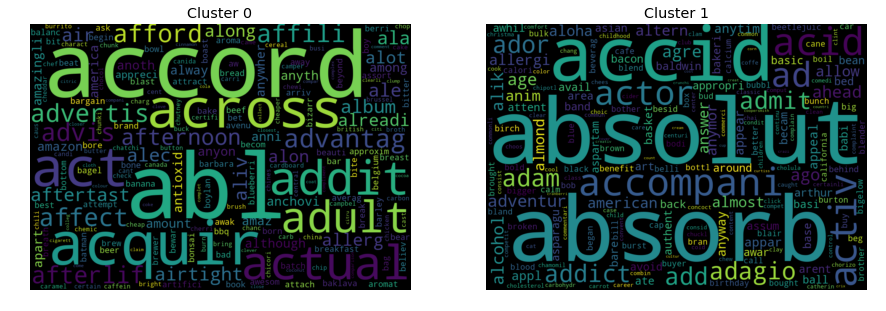

In [183]:
_ = plot_wordcloud(predictions[0], feature_array, width=1000, height=700)

**WordCloud | k = 4**

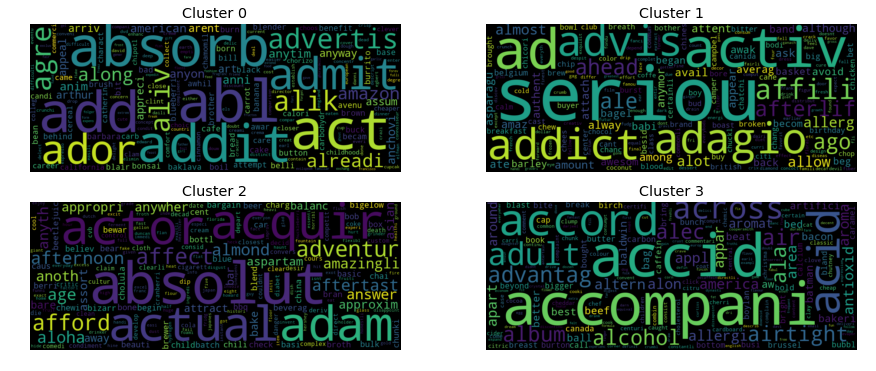

In [170]:
_ = plot_wordcloud(predictions[2], feature_array, width=1000, height=400)

**WordCloud | k = 8**

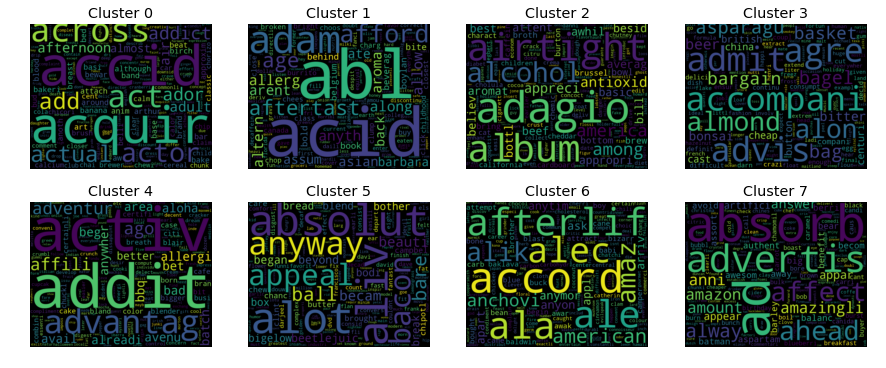

In [177]:
_ = plot_wordcloud(predictions[6], feature_array, width=1000, height=800)

# Conclusion

* Calculated co-occurence matrix from the top 2000 features(words) belonging to Amazon Food Reviews.
* Applied SVD on the matrix and found left singular vectors (word vectors)
* Clustered the words vectors using KMaans clustering and created wordclouds to observe any patterns. 